In [506]:
# resetting the entire session
%reset -f  
# Iris data-set
from sklearn.datasets import load_iris
import numpy as np
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

In [507]:
# activate credencial, one time, if needed
#!/dataVault/activate_IBMProvider.py 

In [508]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((120, 4), (120,))

### Quantum Machine Learning Model
we’ll train a variational quantum classifier (VQC), available in Qiskit Machine Learning 
 Two of its central elements are the feature map and ansatz.

In [509]:
# features circuit
from qiskit.circuit.library import ZZFeatureMap
num_features = X.shape[1]
feature_circ = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_circ.decompose().draw(output='text', fold=-1)

┌───┐┌─────────────┐                                                                                                                                                                                                                            
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■────────────────────────────────────■─────────■─────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │                                    │         │                                         │                                                                                      
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼────────────────────────────────────┼────■────┼────────────────────────────────────■────┼────■────────────────────────────────────■────────────────────────────────────────────
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐┌──────────────────────────────┐┌─┴─┐┌─┴─┐  │  ┌──────────────────────────────┐┌─┴─┐  │    │                                    │                                            
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├──┼──┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├──┼────┼────────────────────────────────────┼────■────────────────────────────────────■──
     ├───┤├─────────────┤                                          └───┘└──────────────────────────────┘└───┘└───┘┌─┴─┐├──────────────────────────────┤└───┘┌─┴─┐┌─┴─┐┌──────────────────────────────┐┌─┴─┐┌─┴─┐┌──────────────────────────────┐┌─┴─┐
q_3: ┤ H ├┤ P(2.0*x[3]) ├─────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[3])) ├─────┤ X ├┤ X ├┤ P(2.0*(π - x[1])*(π - x[3])) ├┤ X ├┤ X ├┤ P(2.0*(π - x[2])*(π - x[3])) ├┤ X ├
     └───┘└─────────────┘                                                                                         └───┘└──────────────────────────────┘     └───┘└───┘└──────────────────────────────┘└───┘└───┘└──────────────────────────────┘└───┘

### Custom Ansatz

In [510]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import ParameterVector

def rotation_block(circ, ir, addRz=True,nq=None):
    # assumes nb of params scales with  num of qubits
    if nq==None:
        nq=circ.num_qubits
    nPar=2*nq-1 if addRz else nq
    thetas = ParameterVector('th%d'%ir, length=nPar)
    for i in range(nq): circ.ry(thetas[i],i)
    if addRz:    
        for i in range(nq-1):  circ.rz(thetas[i+nq],i)

def entangling_block(circ):
    nq=circ.num_qubits
    n2=nq//2
    for i in range(n2): 
        ict=2*i; itg=ict+1
        circ.cx(ict,itg)
    for i in range(n2): 
        ict=2*i+1; itg=(ict+1)%nq
        circ.cx(ict,itg)
                             
def non_linear(circuit,iq):
    beta=np.pi/2 # for midMeas
    # the circuit, the parameter and the qubit of interest
    #circuit.ry(beta, iq)
    circuit.measure(iq, 0)
    #circuit.ry(-beta, iq)

def myAnsatz(nFeat, reps, nMeas, midMeasLL, barrier=True, final_rotation=True):
    assert len(midMeasLL)==reps
    qubits = QuantumRegister(nFeat,'q')
    meas = ClassicalRegister(nMeas,'c')
    qc = QuantumCircuit(qubits, meas)

    for ir in range(reps):
        rotation_block(qc,ir)
        if barrier: qc.barrier()
        entangling_block(qc)
        if barrier: qc.barrier()
        midmL=midMeasLL[ir]
        for iq in midmL: non_linear(qc,iq)            
        if barrier: qc.barrier()
    
    #final rotation block, optional
    if final_rotation:
       rotation_block(qc,ir+1,addRz=False, nq=nFeat//2)
    if barrier: qc.barrier()
    qc.measure(range(nMeas),meas)
 
    return qc
# Anzatz circuit
nReps=3
midMeasLL=[ [] for i in range(nReps) ] # no midMeas at all
midMeasLL=[[2],[3],[]]  # select midMeas qubits per repetition
ansatz_circ = myAnsatz(num_features, reps=nReps, nMeas=2, midMeasLL=midMeasLL, barrier=True, final_rotation=False)
parNames=[param.name for param in ansatz_circ.parameters]
print('Ansatz has %d params:'%(len(parNames)),parNames)
ansatz_circ.decompose().draw(output='text', fold=-1)
#print(ansatz_circ)

Ansatz has 21 params: ['th0[0]', 'th0[1]', 'th0[2]', 'th0[3]', 'th0[4]', 'th0[5]', 'th0[6]', 'th1[0]', 'th1[1]', 'th1[2]', 'th1[3]', 'th1[4]', 'th1[5]', 'th1[6]', 'th2[0]', 'th2[1]', 'th2[2]', 'th2[3]', 'th2[4]', 'th2[5]', 'th2[6]']


global phase: -0.5*th0[4] - 0.5*th0[5] - 0.5*th0[6] - 0.5*th1[4] - 0.5*th1[5] - 0.5*th1[6] - 0.5*th2[4] - 0.5*th2[5] - 0.5*th2[6]
     ┌───────────────┐┌────────────┐ ░           ┌───┐ ░     ░ ┌───────────────┐┌────────────┐ ░           ┌───┐ ░     ░ ┌───────────────┐┌────────────┐ ░           ┌───┐ ░  ░  ░ ┌─┐   
q_0: ┤ R(th0[0],π/2) ├┤ U1(th0[4]) ├─░───■───────┤ X ├─░─────░─┤ R(th1[0],π/2) ├┤ U1(th1[4]) ├─░───■───────┤ X ├─░─────░─┤ R(th2[0],π/2) ├┤ U1(th2[4]) ├─░───■───────┤ X ├─░──░──░─┤M├───
     ├───────────────┤├────────────┤ ░ ┌─┴─┐     └─┬─┘ ░     ░ ├───────────────┤├────────────┤ ░ ┌─┴─┐     └─┬─┘ ░     ░ ├───────────────┤├────────────┤ ░ ┌─┴─┐     └─┬─┘ ░  ░  ░ └╥┘┌─┐
q_1: ┤ R(th0[1],π/2) ├┤ U1(th0[5]) ├─░─┤ X ├──■────┼───░─────░─┤ R(th1[1],π/2) ├┤ U1(th1[5]) ├─░─┤ X ├──■────┼───░─────░─┤ R(th2[1],π/2) ├┤ U1(th2[5]) ├─░─┤ X ├──■────┼───░──░──░──╫─┤M├
     ├───────────────┤├────────────┤ ░ └───┘┌─┴─┐  │   ░ ┌─┐ ░ ├───────────────┤├────────────┤ ░ └───┘┌─┴─┐  │   ░     ░ ├───────────────┤├────────────┤ ░ └───┘┌─┴─┐  │   ░  ░  ░  ║ └╥┘
q_2: ┤ R(th0[2],π/2) ├┤ U1(th0[6]) ├─░───■──┤ X ├──┼───░─┤M├─░─┤ R(th1[2],π/2) ├┤ U1(th1[6]) ├─░───■──┤ X ├──┼───░─────░─┤ R(th2[2],π/2) ├┤ U1(th2[6]) ├─░───■──┤ X ├──┼───░──░──░──╫──╫─
     ├───────────────┤└────────────┘ ░ ┌─┴─┐└───┘  │   ░ └╥┘ ░ ├───────────────┤└────────────┘ ░ ┌─┴─┐└───┘  │   ░ ┌─┐ ░ ├───────────────┤└────────────┘ ░ ┌─┴─┐└───┘  │   ░  ░  ░  ║  ║ 
q_3: ┤ R(th0[3],π/2) ├───────────────░─┤ X ├───────■───░──╫──░─┤ R(th1[3],π/2) ├───────────────░─┤ X ├───────■───░─┤M├─░─┤ R(th2[3],π/2) ├───────────────░─┤ X ├───────■───░──░──░──╫──╫─
     └───────────────┘               ░ └───┘           ░  ║  ░ └───────────────┘               ░ └───┘           ░ └╥┘ ░ └───────────────┘               ░ └───┘           ░  ░  ░  ║  ║ 
c: 2/═════════════════════════════════════════════════════╩═════════════════════════════════════════════════════════╩═══════════════════════════════════════════════════════════════╩══╩═
                                                          0                                                         0                                                               0  1

In [511]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time

loss_hist = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, loss):
    clear_output(wait=True)
    loss_hist.append(loss)
    nIter=len(loss_hist)
    if nIter==1:
        plt.tstart=time.time()
        txt='iter=1'
    else:
        elaT = (time.time() - plt.tstart)/60.
        speed=60*(nIter)/elaT # I missed 0-th iteration
        txt='iteration:%d  elaT=%.1f (min), speed %.1f iter/h,  Objective function=%.2f'%(nIter,elaT,speed,loss)
    print('done:',txt)

    plt.title(txt)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function")
    plt.plot(range(len(loss_hist)), loss_hist)
    plt.grid(color='b', linestyle='--', linewidth=0.5)
    plt.show()

### Training of Qiskit NeuralNetworkClassifier 

In [512]:
if 1:  # backend = density matrix simulator
    from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options, Session
    #load the service
    service = QiskitRuntimeService(channel = 'ibm_quantum')
    backend = service.get_backend('ibmq_qasm_simulator') # change this for a real execution
    # create the program for samplig results on a backend
    options = Options()
    options.resilience_level = 0  # no need to post-process for ideal backend
    options.execution.shots =2000
    session = Session(backend=backend)
    sampler = Sampler(session=session, options=options)
    #sampler = Sampler(backend, options) #if you do not want to use sessions
else:  # backend= state vector 
    assert sum(sum(lst) for lst in midMeasLL) ==0  # it can't handle mid-circui measurements
    from qiskit.primitives import Sampler  # state vector
    sampler = Sampler()

# To make the training process faster, we choose a gradient-free optimizer.
from qiskit.algorithms.optimizers import COBYLA
nIter=120
optimizer = COBYLA(maxiter=nIter)

In [513]:
# construct quantum circuit  (only for inspection)
from qiskit import QuantumCircuit
num_cregs = len(ansatz_circ.clbits) # number of classical registers in the ansatz
circuit = QuantumCircuit(num_features,num_cregs)
circuit.append(feature_circ, range(num_features))
circuit.append(ansatz_circ, range(num_features),range(num_cregs))
circuit.decompose().draw(output="text", fold=-1)

┌────────────────────────────────────┐┌────────────┐┌────────────┐ ░           ┌───┐ ░     ░ ┌────────────┐┌────────────┐ ░           ┌───┐ ░     ░ ┌────────────┐┌────────────┐ ░           ┌───┐ ░  ░  ░ ┌─┐   
q_0: ┤0                                   ├┤ Ry(th0[0]) ├┤ Rz(th0[4]) ├─░───■───────┤ X ├─░─────░─┤ Ry(th1[0]) ├┤ Rz(th1[4]) ├─░───■───────┤ X ├─░─────░─┤ Ry(th2[0]) ├┤ Rz(th2[4]) ├─░───■───────┤ X ├─░──░──░─┤M├───
     │                                    │├────────────┤├────────────┤ ░ ┌─┴─┐     └─┬─┘ ░     ░ ├────────────┤├────────────┤ ░ ┌─┴─┐     └─┬─┘ ░     ░ ├────────────┤├────────────┤ ░ ┌─┴─┐     └─┬─┘ ░  ░  ░ └╥┘┌─┐
q_1: ┤1                                   ├┤ Ry(th0[1]) ├┤ Rz(th0[5]) ├─░─┤ X ├──■────┼───░─────░─┤ Ry(th1[1]) ├┤ Rz(th1[5]) ├─░─┤ X ├──■────┼───░─────░─┤ Ry(th2[1]) ├┤ Rz(th2[5]) ├─░─┤ X ├──■────┼───░──░──░──╫─┤M├
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │├────────────┤├────────────┤ ░ └───┘┌─┴─┐  │   ░ ┌─┐ ░ ├────────────┤├────────────┤ ░ └───┘┌─┴─┐  │   ░     ░ ├────────────┤├────────────┤ ░ └───┘┌─┴─┐  │   ░  ░  ░  ║ └╥┘
q_2: ┤2                                   ├┤ Ry(th0[2]) ├┤ Rz(th0[6]) ├─░───■──┤ X ├──┼───░─┤M├─░─┤ Ry(th1[2]) ├┤ Rz(th1[6]) ├─░───■──┤ X ├──┼───░─────░─┤ Ry(th2[2]) ├┤ Rz(th2[6]) ├─░───■──┤ X ├──┼───░──░──░──╫──╫─
     │                                    │├────────────┤└────────────┘ ░ ┌─┴─┐└───┘  │   ░ └╥┘ ░ ├────────────┤└────────────┘ ░ ┌─┴─┐└───┘  │   ░ ┌─┐ ░ ├────────────┤└────────────┘ ░ ┌─┴─┐└───┘  │   ░  ░  ░  ║  ║ 
q_3: ┤3                                   ├┤ Ry(th0[3]) ├───────────────░─┤ X ├───────■───░──╫──░─┤ Ry(th1[3]) ├───────────────░─┤ X ├───────■───░─┤M├─░─┤ Ry(th2[3]) ├───────────────░─┤ X ├───────■───░──░──░──╫──╫─
     └────────────────────────────────────┘└────────────┘               ░ └───┘           ░  ║  ░ └────────────┘               ░ └───┘           ░ └╥┘ ░ └────────────┘               ░ └───┘           ░  ░  ░  ║  ║ 
c: 2/════════════════════════════════════════════════════════════════════════════════════════╩══════════════════════════════════════════════════════╩════════════════════════════════════════════════════════════╩══╩═
                                                                                             0                                                      0                                                            0  1

### SamplerQNN

In [514]:
def recoLabel(mval):  # mval=int(bistrings)
    if 1: x=mval%3 # --> 0,1,2
    if 0:
        mbits = bin(mval)[2:]
        hw=mbits.count('1')
        x=hw%3
    return x
numLabels = 3  # corresponds to the number of classes, must cover all  possible outcomes of recoLabel(.)

In [515]:
# construct QNN
# see https://github.com/qiskit-community/qiskit-machine-learning/blob/main/docs/tutorials/01_neural_networks.ipynb
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN

# SamplerQNN directly consumes samples from measuring the quantum circuit, it does not require a custom observable.
sampler_qnn = SamplerQNN(
    circuit=circuit.decompose(), #we decompose the circuit because samplerqnn will check if the measurements are present in the circuit
    input_params=feature_circ.parameters,
    weight_params=ansatz_circ.parameters,
    interpret=recoLabel, # interpret  bitstrings.
    output_shape=numLabels, # must match to interpreter
    sampler=sampler
)
'''These output samples are interpreted by default as the probabilities of measuring the integer index c
orresponding to a bitstring. However, the SamplerQNN also allows us to specify an interpret function 
to post-process the samples. This function should be defined so that it takes a measured integer 
(from a bitstring) and maps it to a new value, i.e. non-negative integer.
'''

# construct classifier
model = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=optimizer, callback=callback_graph
)

done: iteration:120  elaT=59.3 (min), speed 121.4 iter/h,  Objective function=0.99


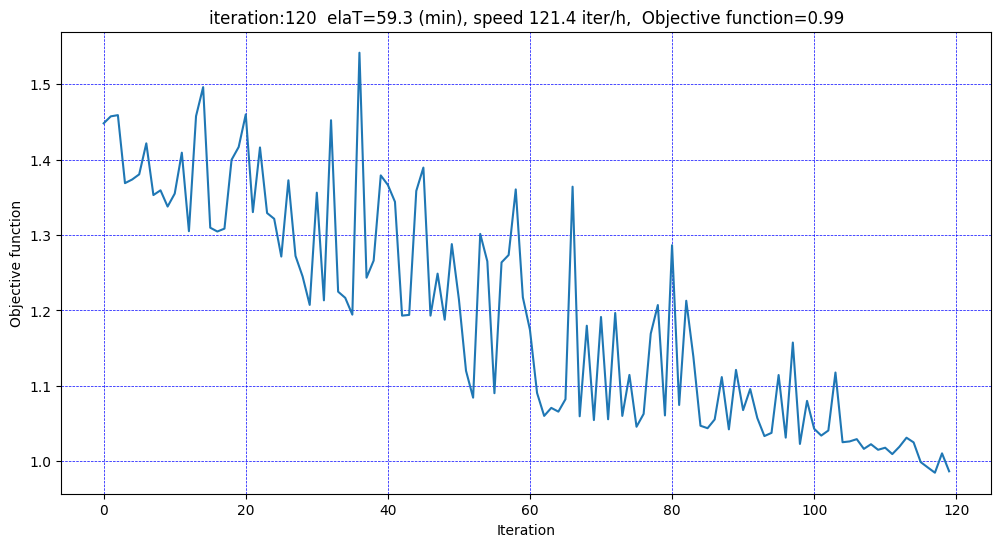

Training time: 3589 seconds, last value:0.99


In [516]:
# create empty array for callback to store evaluations of the objective function
# set figsize
plt.rcParams["figure.figsize"] = (12, 6)
loss_hist = []
start = time.time()

# fit classifier to data
model.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds, last value:%.2f"%loss_hist[-1])

#close your session
#session.close()

### predict for test samples

In [517]:
# Predict labels for the test data
y_pred =model.predict(X_test)
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
#print(conf_matrix)
nSamp=y_pred.shape[0]
nOK=np.sum(y_test==y_pred)
acc=nOK/nSamp
print('\n*test* samples=%d, acc=%.2f  \nconfusion matrix:'%(nSamp,acc))
for i,rec  in enumerate(conf_matrix):
    print('true:%d  reco:%s'%(i,rec))


test samples=30, acc=0.67  
confusion matrix:
true:0  reco:[6 4 0]
true:1  reco:[2 7 0]
true:2  reco:[0 4 7]


In [531]:
# Predict labels for the test data
y_pred_tr =model.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_pred_tr)
#print(conf_matrix)
nSamp=y_pred_tr.shape[0]
nOK=np.sum(y_train==y_pred_tr)
acc=nOK/nSamp
print('\ntrain samples=%d, acc=%.2f  \nconfusion matrix:'%(nSamp,acc))
for i,rec  in enumerate(conf_matrix):
    print('true:%d  reco:%s'%(i,rec))


train samples=120, acc=0.55  
confusion matrix:
true:0  reco:[19 21  0]
true:1  reco:[12 28  1]
true:2  reco:[ 2 18 19]


In [519]:
# run full circuit for 
weights=model.weights
'weihts:',weights.shape, weights

('weihts:',
 (21,),
 array([ 0.86414956, -0.3607599 ,  1.28658179,  0.70686412,  0.3385992 ,
         1.55729213,  1.23032473,  0.41345594,  1.42529304, -0.26311432,
         1.51251378,  1.59357256,  0.16001284,  0.76514663,  0.57049672,
         2.25745553, -0.22997421,  0.34541852,  0.51635798, -0.1308787 ,
         0.56101547]))

In [520]:
nok=0
for p,t in zip(y_pred,y_test):
    print(p,t,p==t)
    nok+=p==t
print('avr prob=%.2f'%(nok/nSamp))

1 1 True
1 0 False
2 2 True
1 1 True
1 1 True
1 0 False
1 1 True
1 2 False
0 1 False
1 1 True
1 2 False
0 0 True
0 0 True
0 0 True
1 0 False
1 1 True
2 2 True
0 1 False
1 1 True
2 2 True
0 0 True
2 2 True
1 0 False
2 2 True
1 2 False
1 2 False
2 2 True
2 2 True
0 0 True
0 0 True
avr prob=0.67


In [521]:
#session.close()

In [522]:
model.save("qnn_classifier.model")

In [523]:
model2 = NeuralNetworkClassifier.load("qnn_classifier.model")

In [524]:
#options.execution.shots =4000
#sampler = Sampler(session=session, options=options)
model2.warm_start = True
model2.neural_network.sampler = sampler
model2.optimizer = COBYLA(maxiter=nIter)
model2.callback=callback_graph

done: iteration:120  elaT=62.2 (min), speed 115.8 iter/h,  Objective function=0.85


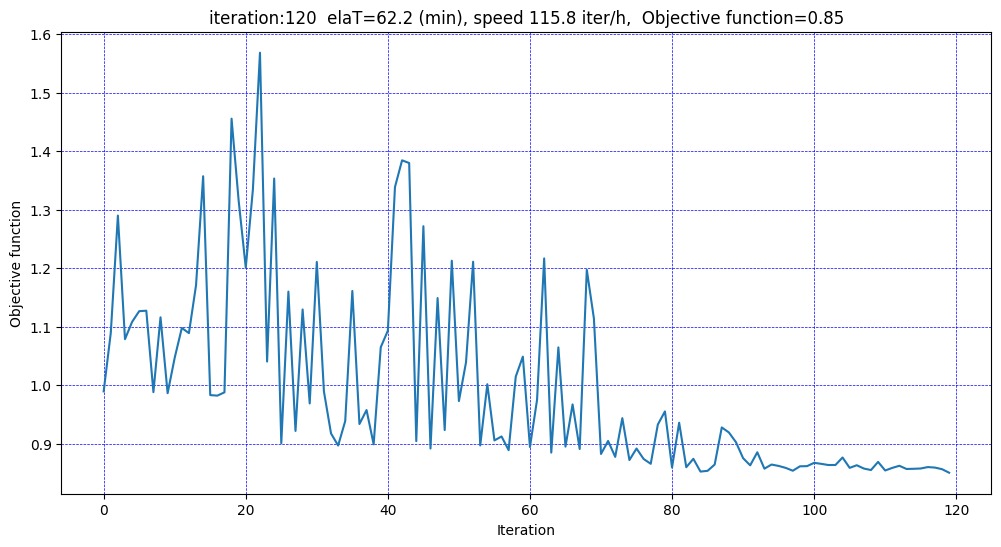

Training time: 3755 seconds, last value:0.85


In [525]:
# clear objective value history
loss_hist = []
start = time.time()
# fit classifier to data
model2.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds, last value:%.2f"%loss_hist[-1])

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)


In [526]:
# Predict labels for the test data
y_pred =model2.predict(X_test)
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
#print(conf_matrix)
nSamp=y_pred.shape[0]
nOK=np.sum(y_test==y_pred)
acc=nOK/nSamp
print('\ntest samples=%d, acc=%.2f \nconfusion matrix:'%(nSamp,acc))
for i,rec  in enumerate(conf_matrix):
    print('true:%d  reco:%s'%(i,rec))


test samples=30, acc=0.30 confusion matrix:
true:0  reco:[ 0 10  0]
true:1  reco:[0 9 0]
true:2  reco:[ 0 11  0]


In [532]:
# Predict labels for the test data
y_pred_tr =model2.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_pred_tr)
#print(conf_matrix)
nSamp=y_pred_tr.shape[0]
nOK=np.sum(y_train==y_pred_tr)
acc=nOK/nSamp
print('\ntrain samples=%d, acc=%.2f  \nconfusion matrix:'%(nSamp,acc))
for i,rec  in enumerate(conf_matrix):
    print('true:%d  reco:%s'%(i,rec))


train samples=120, acc=0.34  
confusion matrix:
true:0  reco:[ 0 40  0]
true:1  reco:[ 0 41  0]
true:2  reco:[ 1 38  0]


In [528]:
def compute_label_prob(x):
    # Calculate the occurrences of each unique value in the array
    values, counts = np.unique(x, return_counts=True)
    # Calculate the probabilities for each unique value
    probabilities = counts / np.sum(counts)
    # Return as a dictionary mapping each unique value to its probability
    return dict(zip(values, probabilities))

# Example usage:
x = np.array([0, 1, 1, 2, 3, 1, 2, 1, 1, 2])  # Replace with any 1D numpy array
probability_distribution = compute_label_prob(x)
print(probability_distribution,x.shape)

{0: 0.1, 1: 0.5, 2: 0.3, 3: 0.1} (10,)


In [529]:
p_test=compute_label_prob(y_test); p_test

{0: 0.3333333333333333, 1: 0.3, 2: 0.36666666666666664}

In [530]:
p_pred=compute_label_prob(y_pred); p_pred

{1: 1.0}